In [38]:
import torch
import json
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def choose_device(device):
    if device==0:
        return 'cuda:0'
    elif device==1:
        return 'cuda:1'
    elif device ==-1:
        return 'cpu'
    else:
        raise Exception('Return 0 or 1 for GPUs or -1 for CPU')

def load_device(cuda_id):
    cuda = choose_device(cuda_id)
    device = torch.device(cuda if torch.cuda.is_available() else "cpu")
    return device

def load_AutoModel(model_id,cuda_id):
    
    tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side = "left") 
    tokenizer.pad_token_id = tokenizer.eos_token_id #required in llama because no padding token is defined
    model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)
    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]
    device = load_device(cuda_id)
    model = model.to(device)

    return tokenizer, model, device, terminators

In [3]:
def compute_layer_vectors(layer_activation):
    return layer_activation[1:]-layer_activation[:-1] #matrix except first_row - matrix except last_row

def compute_vectors(hidden_states):
    return [compute_layer_vectors(layer) for layer in hidden_states]

def compute_angle_layer(layer_vectors):
    angles=[]

    for i in range(layer_vectors.shape[0]-1): 
        #grab consecutive vectors
        a = layer_vectors[i,:]
        b = layer_vectors[i+1,:]
        cos_value = torch.dot(a, b) / (torch.norm(a) * torch.norm(b))
        cos_value = torch.clamp(cos_value, -1, 1)
        angles.append(torch.acos(cos_value)) #angle equation from vec dot product

    return torch.tensor(angles, dtype=torch.bfloat16)

def compute_angle(vector_transitions_trajectory):
    return [compute_angle_layer(layer_vectors) for layer_vectors in vector_transitions_trajectory]

def average_layer_angle(layer_dot_product):
    return layer_dot_product.nanmean() #ignore NaNs when computing mean

def average_angle(dot_product_list):
    return torch.stack([average_layer_angle(layer_dot_product) for layer_dot_product in dot_product_list])

def sum_layer_energy(average_layer_dot_product):
    return average_layer_dot_product.sum()

def energy_pipeline(layer_hidden_states):
    if not isinstance(layer_hidden_states, list):
        raise TypeError("Expected a list of tensors (one per layer of the model). Don't include the model's embedding layer")
    return sum_layer_energy(average_angle(compute_angle(compute_vectors(layer_hidden_states)))).item()

def energy_pipeline_layer(layer_hidden_states):
    if not isinstance(layer_hidden_states, list):
        raise TypeError("Expected a list of tensors (one per layer of the model). Don't include the model's embedding layer")
    return average_angle(compute_angle(compute_vectors(layer_hidden_states)))

In [4]:
def inference_activations(model, gen_ids):
    #pass the full generation through the model 
    with torch.no_grad():
        full_outputs = model(
            input_ids=gen_ids,
            output_hidden_states=True,
            return_dict=True
        )
    #remove 1st tensor dimension so its 2D
    return [layer[0] for layer in full_outputs.hidden_states[1:]] #list with pt tensor of activations in each element

def energy_loop_llama(model_inputs, num_generations, generations, model):
    tensor_size_prompt = model_inputs['input_ids'].shape[1] #obtain prompt token size
    energy_values = []
    for i in range(num_generations):
        tensor = generations[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
        activations = inference_activations(model,tensor)
        energy_values.append(energy_pipeline_layer(activations))

    return energy_values

In [5]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
tokenizer, model, device, terminators = load_AutoModel(model_id, cuda_id=0)

Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00, 133.53it/s]


In [7]:
def load_prompts(prompt_type, prompt_topic):
    #load prompt from .txt
    if prompt_type == 'completion':
        with open('prompts-comp/'+prompt_topic+'.txt') as file:
            prompt = file.read()
    elif prompt_type == 'generation':
        with open('prompts-gen/'+prompt_topic+'.txt') as file:
            prompt = file.read()
        prompt = json.loads(prompt, strict=False)
    return prompt

In [8]:
def prepare_llama_prompt(tokenizer, prompt, device):
    text = tokenizer.apply_chat_template(prompt, add_generation_prompt=True, tokenize=False) 
    inputs = tokenizer(text, padding="longest", return_tensors="pt") #transform into pt tensors
    inputs = {key: val.to(device) for key, val in inputs.items()} #move inputs into cuda
    return inputs

In [ ]:
prompt_type = 'generation' #or 'completion'
prompt_topic='viktor'
prompt = load_prompts(prompt_type, prompt_topic)
viktor = torch.load("checkpoints/ids_viktor.pt")
generations = viktor
nr_gens = viktor.shape[0]
model_inputs = prepare_llama_prompt(tokenizer, prompt, device)
tensor_size_prompt = model_inputs['input_ids'].shape[1] #obtain prompt token size
energy_values = []
for i in range(nr_gens):
    tensor = generations[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
    activations = inference_activations(model,tensor)
    energy_values.append(energy_pipeline_layer(activations))

In [ ]:
prompt_type = 'generation' #or 'completion'
prompt_topic='prague'
prompt = load_prompts(prompt_type, prompt_topic)
generations = torch.load("checkpoints/ids_prague.pt")
nr_gens = generations.shape[0]
model_inputs = prepare_llama_prompt(tokenizer, prompt, device)
tensor_size_prompt = model_inputs['input_ids'].shape[1] #obtain prompt token size
prague_values = []
for i in range(nr_gens):
    tensor = generations[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
    activations = inference_activations(model,tensor)
    prague_values.append(energy_pipeline_layer(activations))

In [ ]:
prompt_type = 'generation' #or 'completion'
prompt_topic='sciencefic'
prompt = load_prompts(prompt_type, prompt_topic)
generations = torch.load("checkpoints/ids_sciencefic.pt")
nr_gens = generations.shape[0]
model_inputs = prepare_llama_prompt(tokenizer, prompt, device)
tensor_size_prompt = model_inputs['input_ids'].shape[1] #obtain prompt token size
science_values = []
for i in range(nr_gens):
    tensor = generations[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
    activations = inference_activations(model,tensor)
    science_values.append(energy_pipeline_layer(activations))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

all_lists = [
    ("Viktor", energy_values, "blue"),
    ("Prague", prague_values, "green"),
    ("Science", science_values, "red")
]

plt.figure(figsize=(12, 6))

for name, energy_list, color in all_lists:
    # Stack tensors to 2D array and convert to float32
    data = torch.stack([t.float() for t in energy_list]).numpy()
    
    # Compute mean and std across layers (or generations) for each neuron index
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    
    x = np.arange(data.shape[1])
    
    # Plot mean line with shaded variance
    plt.plot(x, mean_vals, label=name, color=color)
    plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

plt.xlabel('Layer index')
plt.ylabel('Mean energy value')
plt.title('Energy values per layer comparison')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

all_lists = [
    ("Viktor", energy_values, "blue"),
    ("Prague", prague_values, "green"),
    ("Science", science_values, "red")
]

plt.figure(figsize=(12, 6))

cap_width = 0.2  # width of horizontal caps for min/max

for name, energy_list, color in all_lists:
    data = torch.stack([t.float() for t in energy_list]).numpy()
    
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    mean_vals = np.mean(data, axis=0)
    
    x = np.arange(data.shape[1])
    
    # plot vertical line for min-max
    for xi, vmin, vmax in zip(x, min_vals, max_vals):
        plt.plot([xi, xi], [vmin, vmax], color=color, linewidth=2)
        plt.plot([xi - cap_width, xi + cap_width], [vmin, vmin], color=color, linewidth=2)
        plt.plot([xi - cap_width, xi + cap_width], [vmax, vmax], color=color, linewidth=2)
    
    # optionally plot mean line
    plt.plot(x, mean_vals, color=color, linestyle='--', alpha=0.7)

plt.xlabel('Layer index')
plt.ylabel('Mean energy value')
plt.title('Energy values per layer comparison')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

for name, energy_list in all_energy_values.items():
    # Stack tensors to 2D array and convert to float32
    data = torch.stack([t.float() for t in energy_list]).numpy()
    
    # Compute mean and std across generations
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    
    x = np.arange(data.shape[1])
    
    # Plot mean line with shaded variance
    plt.plot(x, mean_vals, label=name)
    plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2)

plt.xlabel('Neuron index')
plt.ylabel('Energy value')
plt.title('Energy activations for multiple generations')
plt.legend()
plt.show()


## Random vs Normal

In [9]:
prompt_type = 'generation' #or 'completion'
prompt_topic='sciencefic'
prompt = load_prompts(prompt_type, prompt_topic)
model_inputs = prepare_llama_prompt(tokenizer, prompt, device)
tensor_size_prompt = model_inputs['input_ids'].shape[1] #obtain prompt token size

In [10]:
def llama_gen(model, inputs, tokenizer, terminators, num_generations):
    generations = model.generate(
        **inputs,
        max_new_tokens=400,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=terminators,
        num_return_sequences=num_generations  
    )

    return generations

In [11]:
gen_ids = llama_gen(model, model_inputs, tokenizer, terminators, num_generations=100)

In [12]:
prompt_text = tokenizer.decode(model_inputs['input_ids'][0], skip_special_tokens=True)
decoded_gens = tokenizer.batch_decode(gen_ids, skip_special_tokens=True)
decoded_stories = [decoded_generation[len(prompt_text):] for decoded_generation in decoded_gens] 

In [28]:
import random, re
rng = random.Random(42)

def split_sentences(text: str):
    """
    Simple, fast splitter on . ! ?
    For higher quality, swap to blingfire/spacy/syntok later.
    """
    text = text.strip()
    if not text:
        return []
    sents = re.split(r'(?<=[.!?])\s+', text)
    return [s for s in sents if s]

def shuffle_sentences(text: str, rng: random.Random = None) -> str:
    sents = split_sentences(text)
    if len(sents) <= 1:
        return text
    shuffled = sents[:]
    (rng or random).shuffle(shuffled)
    # Ensure it's actually different (rare but possible with small lists)
    if shuffled == sents:
        shuffled = sents[1:] + sents[:1]
    return " ".join(shuffled)

shuffled_stories = [shuffle_sentences(s, rng) for s in decoded_stories]

# 2) Fix padding config (LLaMA often lacks a pad token)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# 3) Choose target shape from your original generations
nr_gens = len(shuffled_stories)
max_gen_size = int(getattr(gen_ids, "shape", [nr_gens, 0])[1])  # fallback if needed

# 4) Re-encode to tensors with fixed length [nr_gens, max_gen_size]
enc = tokenizer(
    shuffled_stories,
    add_special_tokens=False,         # keep it pure story content; set True if you want BOS/EOS
    padding="max_length",
    truncation=True,
    max_length=max_gen_size,
    return_tensors="pt",
)

shuffled_input_ids: torch.Tensor = enc["input_ids"]         # torch.Size([nr_gens, max_gen_size])
shuffled_attention_mask: torch.Tensor = enc["attention_mask"]

assert shuffled_input_ids.shape == (nr_gens, max_gen_size), shuffled_input_ids.shape

In [33]:
shuffled_input_ids      = shuffled_input_ids.to(device)        # dtype should be Long
shuffled_input_ids.shape

torch.Size([100, 534])

In [15]:
good_energies = []
for i in range(gen_ids.shape[0]):
    tensor = gen_ids[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
    activations = inference_activations(model,tensor)
    good_energies.append(energy_pipeline_layer(activations))

In [34]:
bad_energies = []
for i in range(shuffled_input_ids.shape[0]):
    tensor = shuffled_input_ids[i,tensor_size_prompt:].unsqueeze(0) #remove prompt tokens from generation
    activations = inference_activations(model,tensor)
    bad_energies.append(energy_pipeline_layer(activations))

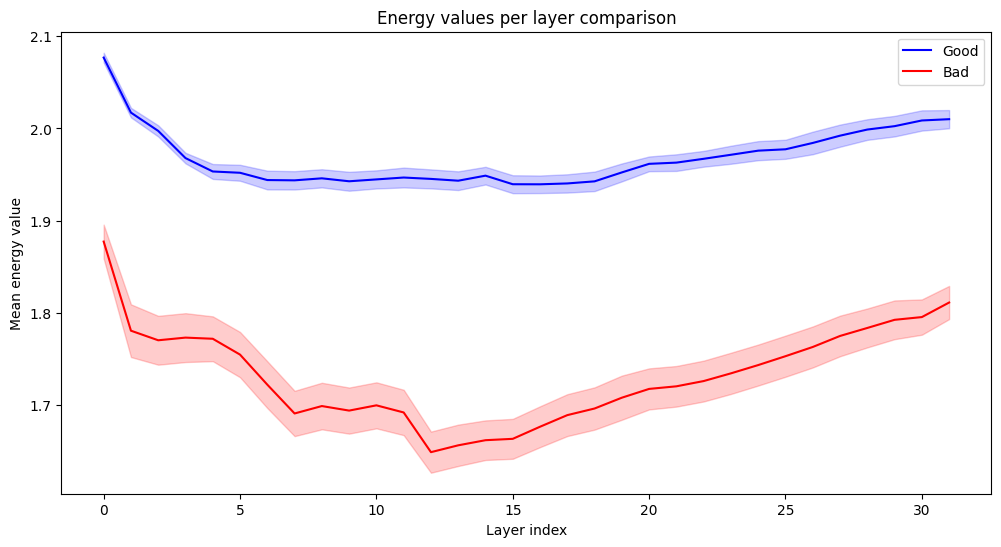

In [39]:
plt.figure(figsize=(12, 6))

all_lists = [
    ("Good", good_energies, "blue"),
    ("Bad", bad_energies, "red"),
]

for name, energy_list, color in all_lists:
    # Stack tensors to 2D array and convert to float32
    data = torch.stack([t.float() for t in energy_list]).numpy()
    
    # Compute mean and std across layers (or generations) for each neuron index
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)
    
    x = np.arange(data.shape[1])
    
    # Plot mean line with shaded variance
    plt.plot(x, mean_vals, label=name, color=color)
    plt.fill_between(x, mean_vals - std_vals, mean_vals + std_vals, color=color, alpha=0.2)

plt.xlabel('Layer index')
plt.ylabel('Mean energy value')
plt.title('Energy values per layer comparison')
plt.legend()
plt.show()